### Brazilian E-Commerce Public Dataset by Olist

Ruby (Ye) Liu   28/02/2024

* This is a Brazilian ecommerce public dataset of orders made at Olist Store. 
* The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil.
* Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers.
* We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

* How to describe a buying process:

When customers decide what they want to buy and click on a product, it creates a timestamp of the time of purchase, and then it will approved by the system.   
The seller gets notified to fulfil that order, then shippng.  
Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note about the purchase experience and write down some comments.

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv

1. Read and Clean the datasets 

2. EDA (9 tables)

* Customer -- Customer unique ID
* Geolocation -- for meat map
* Order Items -- total order value (product + freight)
* Order Payments -- payment type/payment
* Order Reviews -- distribution of score, range 1-5
* Orders -- purchase time
* Products (Top 10 and Bottom 10 products amounts grouped by categories)
* Sellers 
* Product Category -- transfer English name

3. Merge Datasets to Explore the further relationship  (Key Business Insights)
* Order/Revenue Trends: Peak
  * Revenue(payment) group by cities/ states
  * Revenue group by product categories
  * Revenue over year/month/week
  * unique customer count by month

 
* Delivery insights
  
  * correlation between review_score and order_delay
  * chi-square test
  * heat map of customers

4. Model Analysis
* Clustering depending on the customer's behaviours：3 clusters
* Predict review_score by Random Forest
* Time Series/Trend of Revenue


5. How to prove my entire task or further explore (if I have more time)
* Improve model performance
  * Extract more numerical features from the original dataset
  *  choose the more appropriate period for a better predict
* Product Analysis -- Which kind of products have the highest/lowest score?  
* Distance between buyers and sellers.


In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
from matplotlib import pyplot as plt
import re
#plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
import folium
from folium.plugins import HeatMap
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [2]:
olist_customer = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_orders_dataset.csv')
olist_products = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_products_dataset.csv')
olist_sellers = pd.read_csv('C:/Users/13587/Desktop/case aldi//olist_sellers_dataset.csv')
olist_product_category=pd.read_csv('C:/Users/13587/Desktop/case aldi/product_category_name_translation.csv')

%%%%%%products

In [3]:
def analyze_dataset(dataset):
    # Print shape of the dataset
    print(f"Shape of the dataset: {dataset.shape}")

    # Calculate and print missing values
    missing_values = dataset.isnull().sum()
    print(f"Missing values:\n{missing_values}")

    # Calculate and print percentage of missing values
    percentage_missing = (missing_values / len(dataset)) * 100
    print(f"Percentage of missing values:\n{percentage_missing}")

  # Check for duplicate rows
    duplicate_rows = dataset.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_rows}")

    # Print the number of unique values for each column
    unique_values = dataset.nunique(axis=0)
    print(f"Number of unique values for each column:\n{unique_values}")

    # Print general information about the dataset
    print("\nInfo about the dataset:")
    dataset.info()

In [4]:
olist_products.head(3) 

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [5]:
analyze_dataset(olist_products)

Shape of the dataset: (32951, 9)
Missing values:
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
Percentage of missing values:
product_id                    0.000000
product_category_name         1.851234
product_name_lenght           1.851234
product_description_lenght    1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
dtype: float64
Number of duplicate rows: 0
Number of unique values for each column:
product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty     

32951 rows/records including 1.85% missing value,610 rows
delete 611 records, left 32340 records

In [6]:
#df.dtypes
#This dataset includes data about the products sold by Olist.
olist_products=olist_products.dropna() 
print(olist_products.shape)
list(olist_products.columns)

(32340, 9)


['product_id',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm']

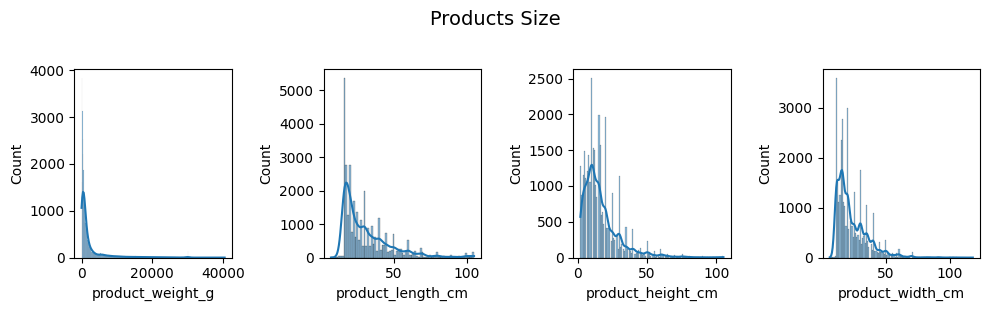

In [7]:
selected_columns = ['product_weight_g','product_length_cm','product_height_cm','product_width_cm']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
axes = axes.flatten()
# Loop , density plots
for i, col in enumerate(selected_columns):
    sns.histplot(olist_products[col], kde=True, ax=axes[i])
    #axes[i].set_title(f'Density Plot: {col}')
fig.suptitle('Products Size', fontsize=14, y=1.02)

plt.tight_layout()
plt.show()

In [8]:
olist_product_category.head(3) 

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


In [9]:
missing_values_product_category = olist_product_category.isnull().sum()
missing_values_product_category

product_category_name            0
product_category_name_english    0
dtype: int64

In [10]:
# Create a dictionary for mapping
category_mapping = dict(zip(olist_product_category['product_category_name'], olist_product_category['product_category_name_english']))

# Replace non-English names with English names
olist_products['product_category_name'] = olist_products['product_category_name'].map(category_mapping)

In [11]:
# Get the top 10 categories
top_categories = olist_products['product_category_name'].value_counts().nlargest(n=10).index
print(top_categories)
# Filter the DataFrame for the top 10 categories
filtered_data_top = olist_products[olist_products['product_category_name'].isin(top_categories)]

# Filter the DataFrame for the bottom 10 categories
bottom_categories = olist_products['product_category_name'].value_counts().nsmallest(10).index
print(bottom_categories)
filtered_data_bottom = olist_products[olist_products['product_category_name'].isin(bottom_categories)]

Index(['bed_bath_table', 'sports_leisure', 'furniture_decor', 'health_beauty',
       'housewares', 'auto', 'computers_accessories', 'toys', 'watches_gifts',
       'telephony'],
      dtype='object', name='product_category_name')
Index(['cds_dvds_musicals', 'security_and_services',
       'fashion_childrens_clothes', 'home_comfort_2', 'tablets_printing_image',
       'la_cuisine', 'furniture_mattress_and_upholstery',
       'diapers_and_hygiene', 'flowers', 'arts_and_craftmanship'],
      dtype='object', name='product_category_name')


In [12]:
# Define the order of categories
category_order_top = filtered_data_top['product_category_name'].value_counts().index
category_order_bottom = filtered_data_bottom['product_category_name'].value_counts().index

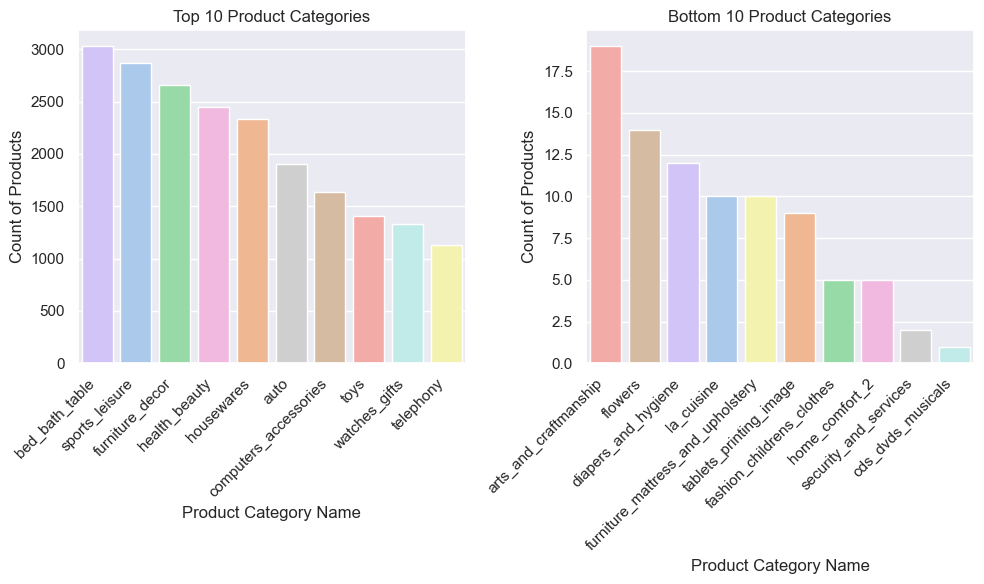

In [13]:
#Countplot and Barplot are two types of plots in Seaborn, a library for data visualization in Python. Countplot is a categorical plot that displays the count of observations for each category, and Barplot is a numerical plot that displays the mean value of a numerical variable for each category.
#Countplot is useful for displaying the distribution of a categorical variable, and it is often used to visualize the frequency of each category. Barplot is useful for comparing the mean value of a numerical variable across different categories

sns.set(style="darkgrid")

fig, ax = plt.subplots(1, 2, figsize=(10, 6))  # Increase figure size
# set the order of categories
sns.countplot(x='product_category_name', data=filtered_data_top, hue='product_category_name', stat='count',palette="pastel", width=0.8, order=category_order_top,ax=ax[0])

ax[0].set_xlabel('Product Category Name')
ax[0].set_ylabel('Count of Products')
ax[0].set_title('Top 10 Product Categories')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better readability
#ax[0].legend(title='Product Category Name', loc='upper right')  # Add legend for better clarity

# Plot for bottom 10 categories
sns.countplot(x='product_category_name', data=filtered_data_bottom, hue='product_category_name', stat='count', palette="pastel", width=0.8, order=category_order_bottom, ax=ax[1])

ax[1].set_xlabel('Product Category Name')
ax[1].set_ylabel('Count of Products')
ax[1].set_title('Bottom 10 Product Categories')  # Corrected title
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better readability
#ax[1].legend(title='Product Category Name', loc='upper right')  # Add legend for better clarity

plt.tight_layout()  
plt.show()

%%%%olist_geolocation%%%%

This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.

In [14]:
olist_geolocation.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


In [15]:
analyze_dataset(olist_geolocation)

Shape of the dataset: (1000163, 5)
Missing values:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
Percentage of missing values:
geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64
Number of duplicate rows: 261831
Number of unique values for each column:
geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

Info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_

In [16]:
# Drop duplicates data
olist_geolocation.drop_duplicates(inplace=True)
olist_geolocation.duplicated().sum()

0

In [17]:
olist_geolocation.shape

(738332, 5)

Duplicates: The dataset has a very large number of duplicate rows (261,831), which suggests either a data entry issue or that the data collection process captured multiple entries for the same geolocation points.

In [18]:
# Unique states count
unique_states_count = olist_geolocation['geolocation_state'].nunique()

# Unique cities count
unique_cities_count = olist_geolocation['geolocation_city'].nunique()

print(f"Count of Unique States: {unique_states_count}")
print(f"Count of Unique Cities: {unique_cities_count}")
#geolocation = olist_geolocation['geolocation_state'].value_counts().nlargest(n=10).index
#print(geolocation)

Count of Unique States: 27
Count of Unique Cities: 8011


In [19]:
# function to replace non-standard special characters with standard characters in a string
def replace_char(city_name):
    city_name = re.sub(r'[ãââàáä]', 'a', city_name)
    city_name = re.sub(r'[íîì]', 'i', city_name)
    city_name = re.sub(r'[úûùü]', 'u', city_name)
    city_name = re.sub(r'[éêèë]', 'e', city_name)
    city_name = re.sub(r'[óõôòö]', 'o', city_name)
    city_name = re.sub(r'[ç]', 'c', city_name)
    return city_name

# Applying the function to clean 'geolocation_city' column
olist_geolocation['geolocation_city'] = olist_geolocation['geolocation_city'].apply(replace_char)

In [20]:
# Searching for city names that do not follow a pattern
# Filter invalid city names based on pattern
def filtered_city(data, col):
    pattern = re.compile("[^a-z\sA-Z0-9-\'+]")
    filtered_df = data[data[col].str.contains(pattern)]
    return filtered_df
#filtered_city(olist_geolocation, 'geolocation_city')


In [21]:
# Cleaning all geolocation city
for i in olist_geolocation['geolocation_zip_code_prefix'].unique():
    mode_city = olist_geolocation[olist_geolocation['geolocation_zip_code_prefix'] == i]['geolocation_city'].mode().values[0]
    olist_geolocation.loc[olist_geolocation['geolocation_zip_code_prefix'] == i, 'geolocation_city'] = mode_city
    
# Convert the city name column to title case
olist_geolocation['geolocation_city'] = olist_geolocation['geolocation_city'].str.title()

# Searching for city names that do not follow a pattern
filtered_city(olist_geolocation, 'geolocation_city')

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state


In [22]:
olist_geolocation['geolocation_city'].value_counts()

geolocation_city
Sao Paulo           99650
Rio De Janeiro      35178
Belo Horizonte      19475
Curitiba            11264
Brasilia             9073
                    ...  
Canhoba                 1
Fonseca                 1
Senhora Do Carmo        1
Barra Feliz             1
Muribeca                1
Name: count, Length: 5771, dtype: int64

In [23]:
olist_geolocation= olist_geolocation.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'})
#olist_geolocation= olist_geolocation.rename(columns={'customer_zip_code_prefix': 'seller_zip_code_prefix'})

%%%%%%%customer%%%%%

In [24]:
olist_customer.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [25]:
analyze_dataset(olist_customer)

Shape of the dataset: (99441, 5)
Missing values:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Percentage of missing values:
customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64
Number of duplicate rows: 0
Number of unique values for each column:
customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441

In [26]:
percentage_unique_customers = round((olist_customer['customer_unique_id'].nunique() / len(olist_customer['customer_id'])) * 100, 3)
print(percentage_unique_customers,'% Customers only purchase once')

96.636 % Customers only purchase once


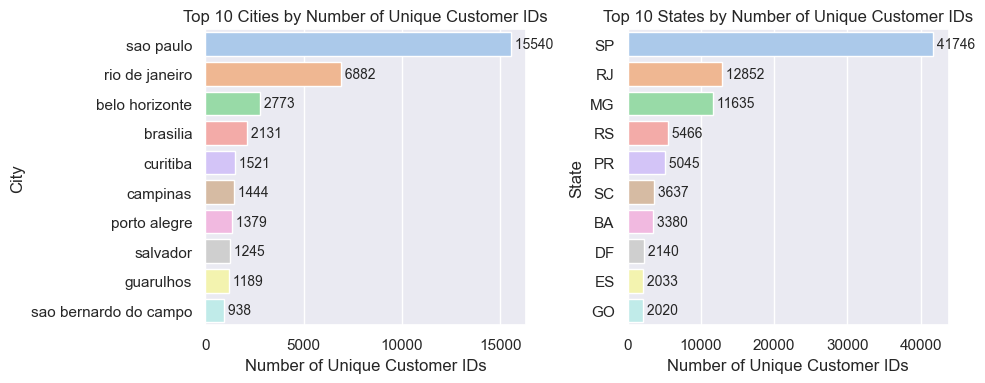

In [27]:
# Grouping and sorting
top_cities = olist_customer.groupby('customer_city')['customer_id'].nunique().sort_values(ascending=False).head(10)
top_states = olist_customer.groupby('customer_state')['customer_id'].nunique().sort_values(ascending=False).head(10)

sns.set(style="darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the bar chart for top 10 cities
city_plot = sns.barplot(x=top_cities.values, y=top_cities.index, ax=ax[0],palette="pastel")
ax[0].set_title('Top 10 Cities by Number of Unique Customer IDs')
ax[0].set_xlabel('Number of Unique Customer IDs')
ax[0].set_ylabel('City')

# Adding counts on the bars
for i, value in enumerate(top_cities.values):
    city_plot.text(value, i, f' {value}', va='center', fontsize=10)

# Plotting the bar chart for top 10 states
state_plot = sns.barplot(x=top_states.values, y=top_states.index, ax=ax[1],palette="pastel")
ax[1].set_title('Top 10 States by Number of Unique Customer IDs')
ax[1].set_xlabel('Number of Unique Customer IDs')
ax[1].set_ylabel('State')

# Adding counts on the bars
for i, value in enumerate(top_states.values):
    state_plot.text(value, i, f' {value}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


%%%%olist_order_payments%%%%

In [28]:
analyze_dataset(olist_order_payments)

Shape of the dataset: (103886, 5)
Missing values:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
Percentage of missing values:
order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64
Number of duplicate rows: 0
Number of unique values for each column:
order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

Info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  obj

In [29]:
olist_order_payments.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


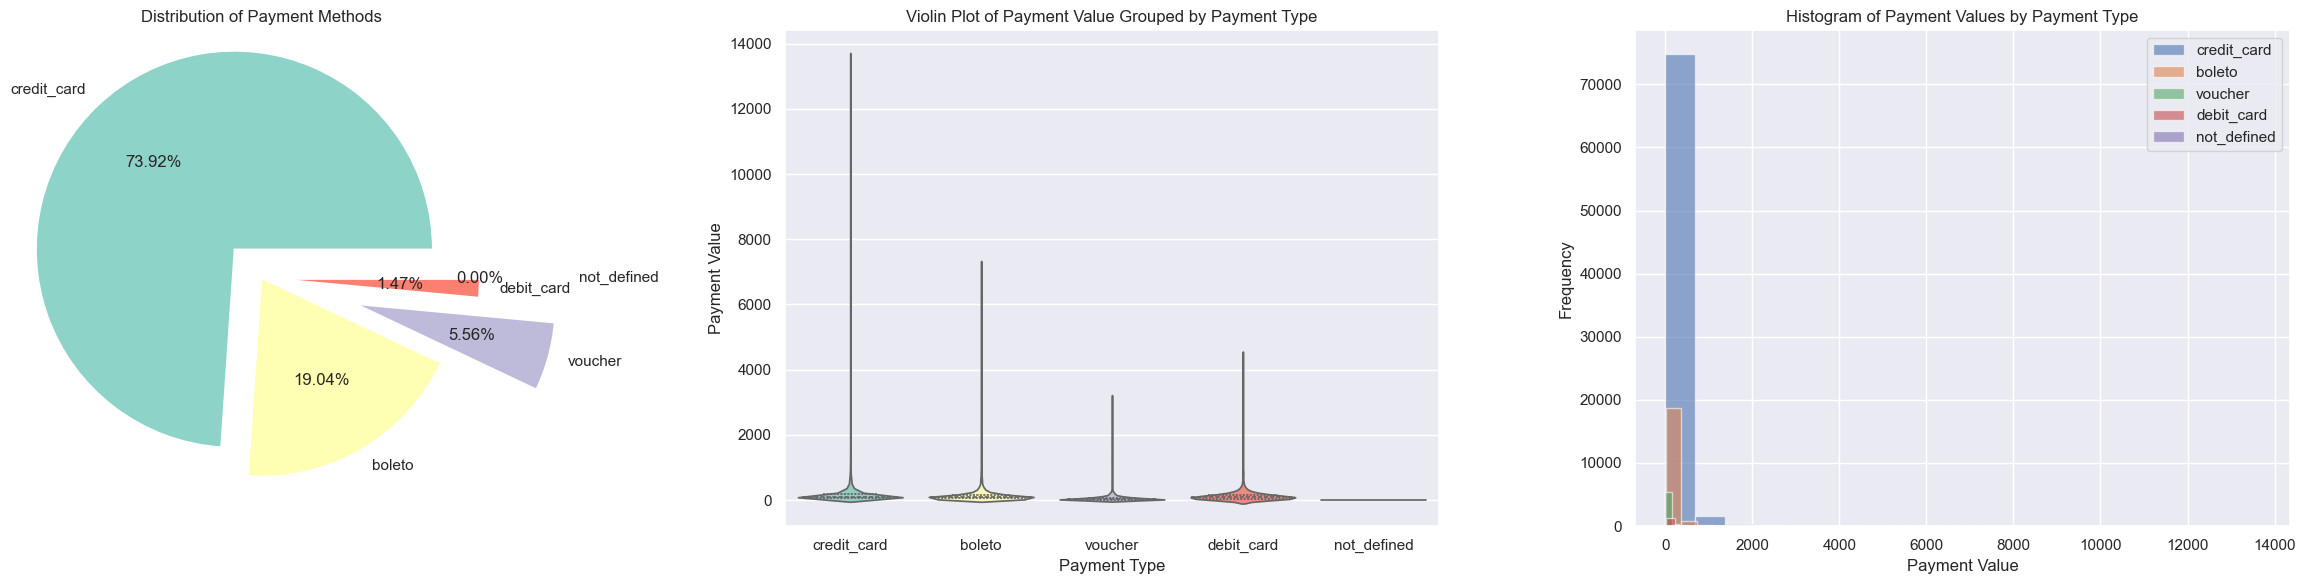

In [30]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
paytype_count = olist_order_payments['payment_type'].value_counts()
explode = (0.2, 0, 0.5, 0.1, 0.5)
axs[0].pie(
    paytype_count,
    labels=paytype_count.index,
    autopct='%1.2f%%',
    explode=explode,
    colors=sns.color_palette('Set3')
)
axs[0].set_title('Distribution of Payment Methods')

# violin plot
sns.violinplot(x='payment_type', y='payment_value', data=olist_order_payments, inner="quartile", palette="Set3", saturation=0.8, ax=axs[1])
axs[1].set_title('Violin Plot of Payment Value Grouped by Payment Type')
axs[1].set_xlabel('Payment Type')
axs[1].set_ylabel('Payment Value')

for payment_type in olist_order_payments['payment_type'].unique():
    # Filter the data for each payment type
    subset = olist_order_payments[olist_order_payments['payment_type'] == payment_type]
    
    # Plot histogram for each payment type
    axs[2].hist(subset['payment_value'], bins=20, alpha=0.6, label=payment_type)

axs[2].set_xlabel('Payment Value')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Histogram of Payment Values by Payment Type')
axs[2].legend()
plt.tight_layout()
plt.show()

A large amount of payment is made via credit card， then is boleto(cash-based method in Brazil) currency unit：Brazilian Real

%%%%%olist_sellers%%%%%

In [31]:
olist_sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [32]:
analyze_dataset(olist_sellers)

Shape of the dataset: (3095, 4)
Missing values:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
Percentage of missing values:
seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64
Number of duplicate rows: 0
Number of unique values for each column:
seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

Info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64

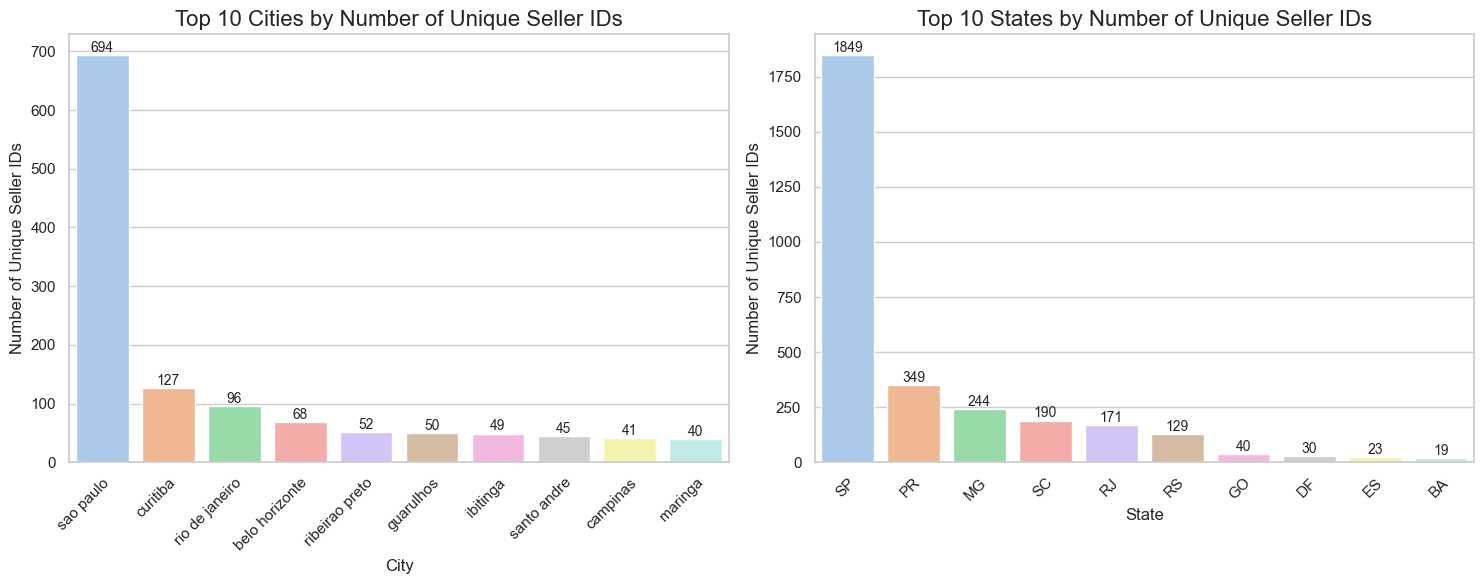

In [33]:
# Grouping by 'seller_city' and counting unique seller IDs
sellercity = olist_sellers.groupby('seller_city')['seller_id'].nunique().sort_values(ascending=False).head(10)

# Grouping by 'state'
sellers_by_state = olist_sellers.groupby('seller_state')['seller_id'].nunique().sort_values(ascending=False).head(10)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=sellercity.index, y=sellercity, palette="pastel")
plt.title('Top 10 Cities by Number of Unique Seller IDs', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Unique Seller IDs', fontsize=12)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
for index, value in enumerate(sellercity):
    plt.text(index, value + 0.2, str(value), ha='center', va='bottom', fontsize=10)
plt.tight_layout()

# Plotting the second subplot (sellers_by_state) 
plt.subplot(1, 2, 2)
sns.barplot(x=sellers_by_state.index, y=sellers_by_state, palette="pastel")
plt.title('Top 10 States by Number of Unique Seller IDs', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Unique Seller IDs', fontsize=12)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
for index, value in enumerate(sellers_by_state):
    plt.text(index, value + 0.2, str(value), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

%%%%%order_items%%%

This dataset includes data about the items purchased within each order.


In [34]:
olist_order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [35]:
analyze_dataset(olist_order_items)

Shape of the dataset: (112650, 7)
Missing values:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
Percentage of missing values:
order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64
Number of duplicate rows: 0
Number of unique values for each column:
order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   o

In [36]:
olist_order_items['shipping_limit_date'] = pd.to_datetime(olist_order_items['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')
olist_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


The order_id = 00143d0f86d6fbd9f9b38ab440ac16f5 has 3 items (same product). Each item has the freight calculated accordingly to its measures and weight. To get the total freight value for each order you just have to sum.

The total order_item value is: 21.33 * 3 = 63.99

The total freight value is: 15.10 * 3 = 45.30

The total order value (product + freight) is: 45.30 + 63.99 = 109.29

In [37]:
# Identify rows where order_id is repeated
duplicate_orders = olist_order_items[olist_order_items.duplicated(subset='order_id', keep=False)]
#duplicate_orders

In [38]:
# Get the maximum 'order_item_id' for each 'order_id'
# item_sum = olist_order_items.groupby('order_id')['order_item_id'].transform('max')
# item_sum
#item_sum = olist_order_items.groupby('order_id')['order_item_id'].max()

olist_order_items=olist_order_items.groupby('order_id').apply(lambda t: t[t.order_item_id==t.order_item_id.max()])
#result_item_sum=item_sum.reset_index()
# Reset the index to make it a DataFrame

In [39]:
#check the results
#result_df = item_sum[item_sum['order_item_id'] == 3]
# Print the result
#len(result_df)
#result_df.head()

In [40]:
olist_order_items['sum_value']=olist_order_items['order_item_id']*(olist_order_items['price']+olist_order_items['freight_value'])

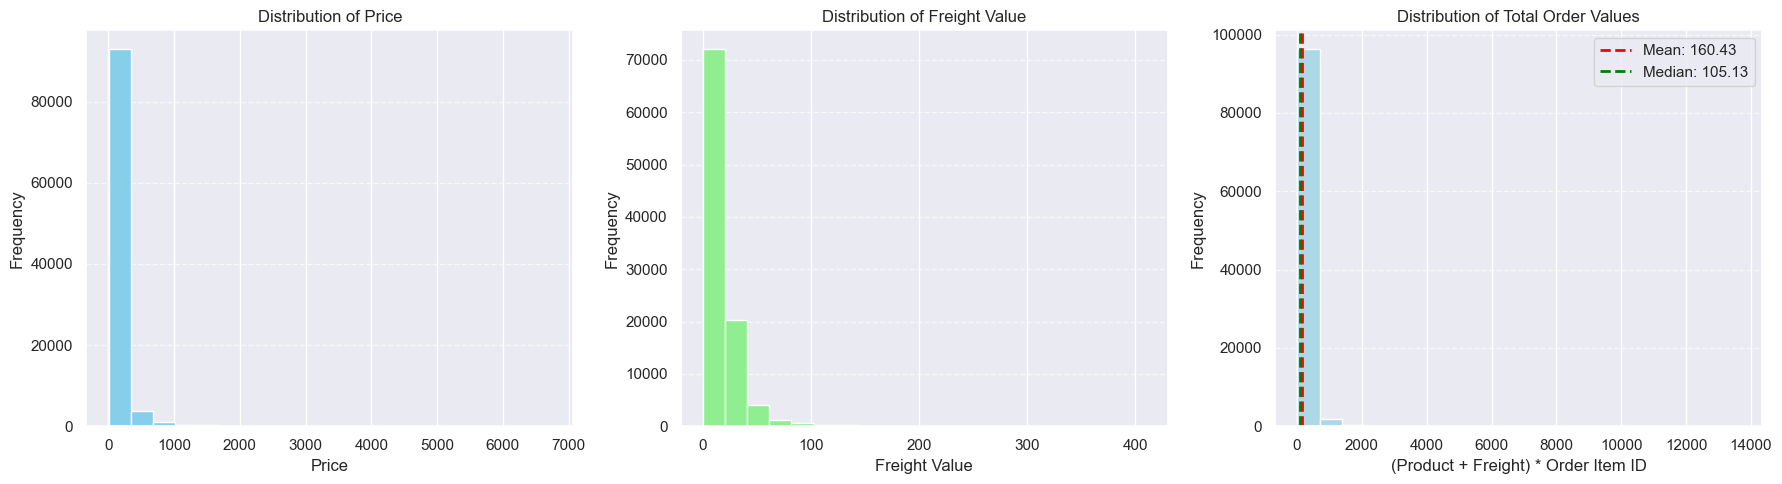

In [41]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot histogram for 'price'
axes[0].hist(olist_order_items['price'], bins=20, color='skyblue', edgecolor='white')
axes[0].set_title('Distribution of Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot histogram for 'freight_value'
axes[1].hist(olist_order_items['freight_value'], bins=20, color='lightgreen', edgecolor='white')
axes[1].set_title('Distribution of Freight Value')
axes[1].set_xlabel('Freight Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot histogram for 'sum_value'
axes[2].hist(olist_order_items['sum_value'], bins=20, color='lightblue', edgecolor='white')
axes[2].set_xlabel('(Product + Freight) * Order Item ID')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Total Order Values')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

mean_value = olist_order_items['sum_value'].mean()
median_value = olist_order_items['sum_value'].median()
axes[2].axvline(x=mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
axes[2].axvline(x=median_value, color='green', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

In [42]:
item_sum=olist_order_items.copy()

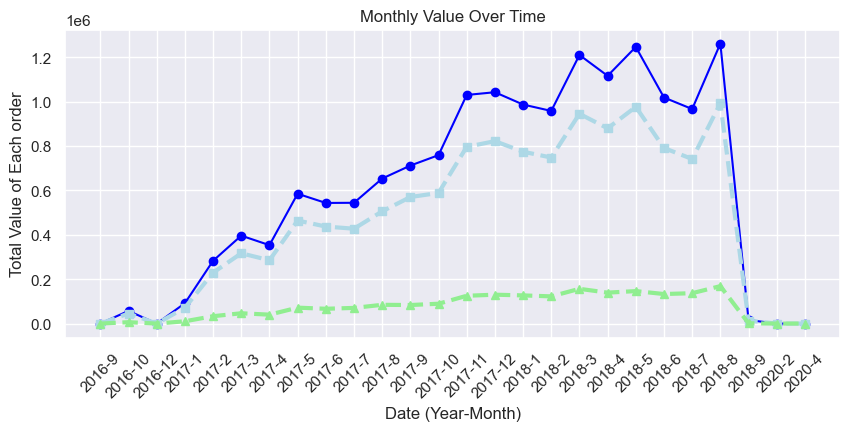

In [43]:
item_sum['Year']=item_sum['shipping_limit_date'].dt.year
item_sum['Month']=item_sum['shipping_limit_date'].dt.month

item_sum_grouped_data = item_sum.groupby(['Year', 'Month']).agg({'sum_value': 'sum', 'price': 'sum', 'freight_value': 'sum'}).reset_index()

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(item_sum_grouped_data['Year'].astype(str) + '-' + item_sum_grouped_data['Month'].astype(str), item_sum_grouped_data['sum_value'], marker='o',label='sum_value', color='blue')
plt.plot(item_sum_grouped_data['Year'].astype(str) + '-' + item_sum_grouped_data['Month'].astype(str), item_sum_grouped_data['price'], marker='s',label='price', color='lightblue',linestyle='dashed', linewidth=3)
plt.plot(item_sum_grouped_data['Year'].astype(str) + '-' + item_sum_grouped_data['Month'].astype(str), item_sum_grouped_data['freight_value'], marker='^',label='freight_value', color='lightgreen',linestyle='dashed', linewidth=3)

plt.title('Monthly Value Over Time')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Total Value of Each order')
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

from the significant data shows it has an upward growth trend,fluctuant, 2016-09 to 2018-08  
steep descent - no records/ not enough records

%%%%%order_reviews%%%

In [44]:
olist_order_reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [45]:
analyze_dataset(olist_order_reviews)

Shape of the dataset: (99224, 7)
Missing values:
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
Percentage of missing values:
review_id                   0.000000
order_id                    0.000000
review_score                0.000000
review_comment_title       88.341530
review_comment_message     58.702532
review_creation_date        0.000000
review_answer_timestamp     0.000000
dtype: float64
Number of duplicate rows: 0
Number of unique values for each column:
review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4527
review_comment_message     36159
review_creation_date         636
review_answer_timestamp    98248
dtype: int64

Info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 

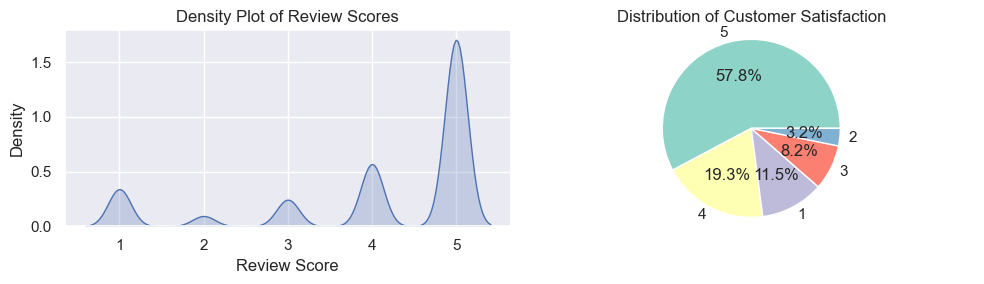

In [46]:
reviewscore = olist_order_reviews['review_score'].value_counts()
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plotting the density plot in the first subplot
sns.kdeplot(data=olist_order_reviews, x="review_score", fill=True, palette="viridis", ax=axes[0])
axes[0].set_title('Density Plot of Review Scores')
axes[0].set_xlabel('Review Score')
axes[0].set_ylabel('Density')

axes[1].pie(reviewscore, labels=reviewscore.index, autopct='%1.1f%%', colors=plt.cm.Set3.colors)
axes[1].set_title('Distribution of Customer Satisfaction')
axes[1].axis('equal')  # Equal aspect ratio ensures that the pie chart is circular

plt.tight_layout()
plt.show()

%%%%%order_orders%%%%

In [47]:
olist_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [48]:
analyze_dataset(olist_orders)

Shape of the dataset: (99441, 8)
Missing values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
Percentage of missing values:
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64
Number of duplicate rows: 0
Number of unique values for each column:
order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at           

In [49]:
olist_orders['order_purchase_timestamp'] = pd.to_datetime(olist_orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
olist_orders['order_approved_at'] = pd.to_datetime(olist_orders['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
olist_orders['order_delivered_carrier_date'] = pd.to_datetime(olist_orders['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
olist_orders['order_delivered_customer_date'] = pd.to_datetime(olist_orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
olist_orders['order_estimated_delivery_date'] = pd.to_datetime(olist_orders['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')
olist_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [50]:
olist_orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


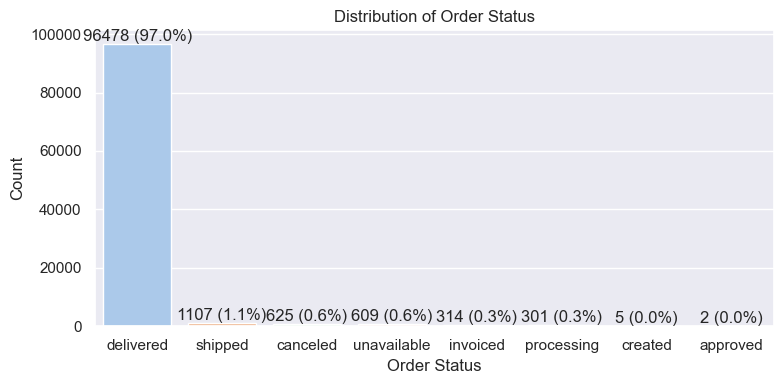

In [51]:
order_status = olist_orders['order_status'].value_counts()
order_status_percentage = (order_status / order_status.sum()) * 100
colors = sns.color_palette('pastel')[0:len(order_status)]
plt.figure(figsize=(8, 4))
sns.barplot(x=order_status.index, y=order_status.values, palette=colors)
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.title('Distribution of Order Status')

for i, (v, p) in enumerate(zip(order_status.values, order_status_percentage.values)):
    plt.text(i, v + 0.1, f'{v} ({p:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [52]:
olist_orders = olist_orders[olist_orders['order_status'] == 'delivered']

In [53]:
##### convert with customers
olist_geolocation = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_geolocation_dataset.csv')
olist_geolocation.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'}, inplace=True)

In [54]:
##### convert with sellers
#olist_geolocation = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_geolocation_dataset.csv')
#olist_geolocation.rename(columns={'geolocation_zip_code_prefix': 'seller_zip_code_prefix'}, inplace=True)

merge data explore relation with multiple table

In [55]:
data=olist_customer.copy()

In [56]:
olist_orders.reset_index(drop = True, inplace = True)
olist_order_items.reset_index(drop = True, inplace = True)
olist_products.reset_index(drop = True, inplace = True)

In [57]:
# # inner join
data = pd.merge(olist_customer, olist_orders, on='customer_id')
data = pd.merge(data, olist_order_items, on='order_id')
data = pd.merge(data, olist_products, on='product_id')
data = pd.merge(data, olist_sellers, on='seller_id')
#data = pd.merge(data, olist_geolocation, on='geolocation_zip_code_prefix')
data = pd.merge(data, olist_order_reviews, on='order_id')
data = pd.merge(data, olist_order_payments, on='order_id')

In [58]:
data.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'sum_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

In [64]:
df = data.drop(['product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'review_id','payment_sequential',
       'payment_type', 'payment_installments','order_status','seller_id','review_comment_title',
       'review_comment_message', 'review_creation_date','order_item_id','product_id',
       'review_answer_timestamp' ,'customer_id','review_comment_title','review_comment_message'], axis=1)

In [65]:
df.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'price', 'freight_value', 'sum_value',
       'product_category_name', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'review_score', 'payment_value'],
      dtype='object')

In [66]:
df.shape

(99203, 20)

In [67]:
df= df.drop_duplicates()

In [68]:
# Extract the year and month from the timestamp
df['Year_Month'] = df['order_purchase_timestamp'].dt.to_period('M')
df['Year']=df['order_purchase_timestamp'].dt.year
df['Month']=df['order_purchase_timestamp'].dt.month
df['Year_Month'] = df['Year_Month'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98298 entries, 0 to 99202
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             98298 non-null  object        
 1   customer_zip_code_prefix       98298 non-null  int64         
 2   customer_city                  98298 non-null  object        
 3   customer_state                 98298 non-null  object        
 4   order_id                       98298 non-null  object        
 5   order_purchase_timestamp       98298 non-null  datetime64[ns]
 6   order_approved_at              98285 non-null  datetime64[ns]
 7   order_delivered_carrier_date   98296 non-null  datetime64[ns]
 8   order_delivered_customer_date  98290 non-null  datetime64[ns]
 9   order_estimated_delivery_date  98298 non-null  datetime64[ns]
 10  shipping_limit_date            98298 non-null  datetime64[ns]
 11  price               

In [69]:
df['order_delivered_customer_date'].head()

0   2017-05-25 10:35:35
1   2017-11-28 00:09:50
2   2017-05-26 09:54:04
3   2018-02-28 21:09:00
4   2017-04-11 10:16:56
Name: order_delivered_customer_date, dtype: datetime64[ns]

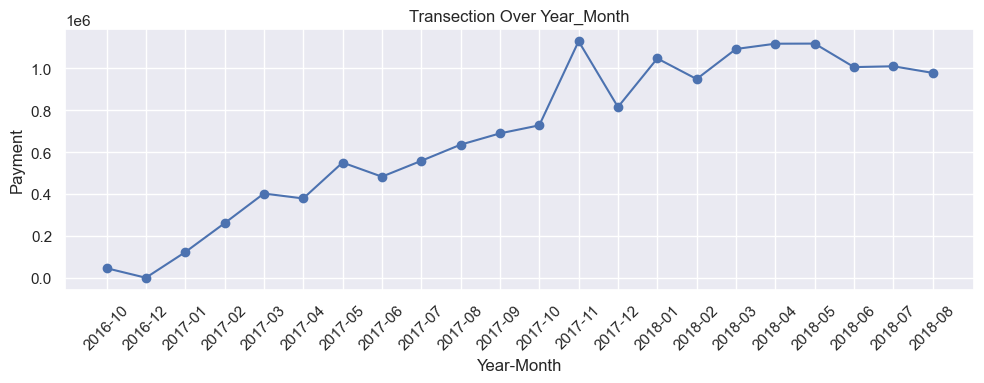

In [70]:
# Group by 'Year_Month'(transection over Year-Month)
df_transection = df.groupby('Year_Month')['payment_value'].sum().reset_index()
df_transection = df_transection.sort_values(by='Year_Month')

plt.figure(figsize=(10, 4))
plt.plot(df_transection['Year_Month'], df_transection['payment_value'], marker='o', linestyle='-')
plt.title('Transection Over Year_Month')
plt.xlabel('Year-Month')
plt.ylabel('Payment')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


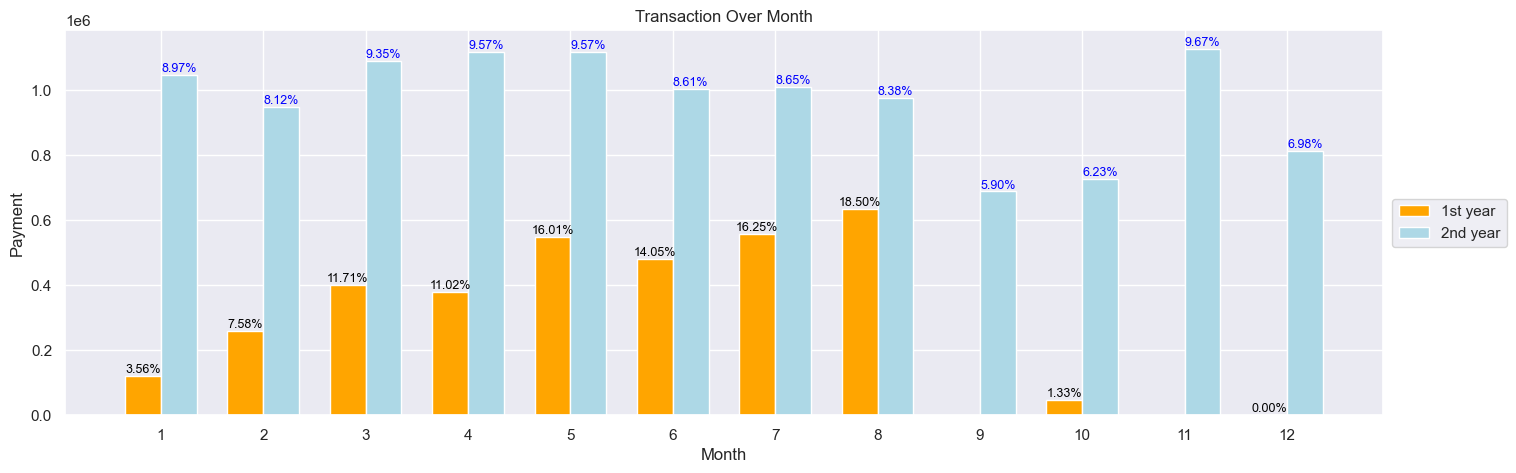

In [73]:
#2016-09 to 2017-08; 2017-09 to 2018-09
df_1st = df[(df['Year_Month'] >= '2016-09') & (df['Year_Month'] <= '2017-08')]
df_2nd = df[(df['Year_Month'] >= '2017-09') & (df['Year_Month'] <= '2018-09')]
# Group by 'Month'(transaction over Avg-Month)
df_transection_month_1st = df_1st.groupby('Month')['payment_value'].sum().reset_index()
df_transection_month_2nd = df_2nd.groupby('Month')['payment_value'].sum().reset_index()

# Avg Transection based on the month (month=(1-8,10-12) /2, month=9 /3)
# df_transection_month_1st['Avg_Payment'] = df_transection_month_1st.apply(
#     lambda row: row['payment_value'] / 3 if row['Month'] == 9 else row['payment_value'] / 2, axis=1
# )

# Sort by 'Month' for both date ranges
bar_width = 0.35
index = np.arange(1, 13)
df_transection_month_1st = df_transection_month_1st.set_index('Month').reindex(range(1, 13)).reset_index()
df_transection_month_2nd = df_transection_month_2nd.set_index('Month').reindex(range(1, 13)).reset_index()

# Create a figure and axis
plt.figure(figsize=(17, 5))
plt.bar(index, df_transection_month_1st['payment_value'], bar_width, color='orange', label='1st year')
plt.bar(index + bar_width, df_transection_month_2nd['payment_value'], bar_width, color='lightblue', label='2nd year')

# Add percentage labels
for x, y1, y2 in zip(index, df_transection_month_1st['payment_value'], df_transection_month_2nd['payment_value']):
    plt.text(x, y1 + 50, f'{(y1 / df_transection_month_1st["payment_value"].sum()) * 100:.2f}%', ha='center', va='bottom', color='black', fontsize=9)
    plt.text(x + bar_width, y2 + 50, f'{(y2 / df_transection_month_2nd["payment_value"].sum()) * 100:.2f}%', ha='center', va='bottom', color='blue', fontsize=9)


plt.title('Transaction Over Month')
plt.xlabel('Month')
plt.ylabel('Payment')
plt.xticks(index + bar_width / 2, range(1, 13))
plt.legend(loc='right', bbox_to_anchor=(1.1, 0.5))
plt.show()

In [74]:
df_1st['Day_Name'] = df_1st['order_purchase_timestamp'].dt.strftime('%a')
df_2nd['Day_Name'] = df_2nd['order_purchase_timestamp'].dt.strftime('%a')
print(min(df_1st['order_purchase_timestamp']))
print(max(df_1st['order_purchase_timestamp']))
print(min(df_2nd['order_purchase_timestamp']))
print(max(df_2nd['order_purchase_timestamp']))

2016-10-03 09:44:50
2017-08-31 23:37:47
2017-09-01 00:03:50
2018-08-29 15:00:37


In [75]:
# Group by 'Day' and sum the 'payment' for each day
df_payment_by_day_1st = df_1st.groupby('Day_Name')['payment_value'].sum().reset_index()
df_payment_by_day_2nd = df_2nd.groupby('Day_Name')['payment_value'].sum().reset_index()

In [76]:
df_payment_by_day_1st['Avg_Payment'] = df_payment_by_day_1st.apply(
    lambda row: round(row['payment_value'] / 51, 2) if row['Day_Name'] in ['Fri', 'Sat'] else round(row['payment_value'] / 52, 2),
    axis=1
)
df_payment_by_day_2nd['Avg_Payment'] = df_payment_by_day_2nd.apply(
    lambda row: round(row['payment_value'] / 52, 2) if row['Day_Name'] in ['Tue', 'Wed','Thu'] else round(row['payment_value'] / 53, 2),
    axis=1
)

In [77]:
cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_payment_by_day_2nd['Day_Name'] = pd.Categorical(df_payment_by_day_2nd['Day_Name'], categories=cats, ordered=True)
df_payment_by_day_2nd = df_payment_by_day_2nd.sort_values('Day_Name')
#df_payment_by_day_2nd=df_payment_by_day_2nd.reset_index()
df_payment_by_day_1st['Day_Name'] = pd.Categorical(df_payment_by_day_1st['Day_Name'], categories=cats, ordered=True)
df_payment_by_day_1st = df_payment_by_day_1st.sort_values('Day_Name')

#df_payment_by_day_1st=df_payment_by_day_1st.reset_index()

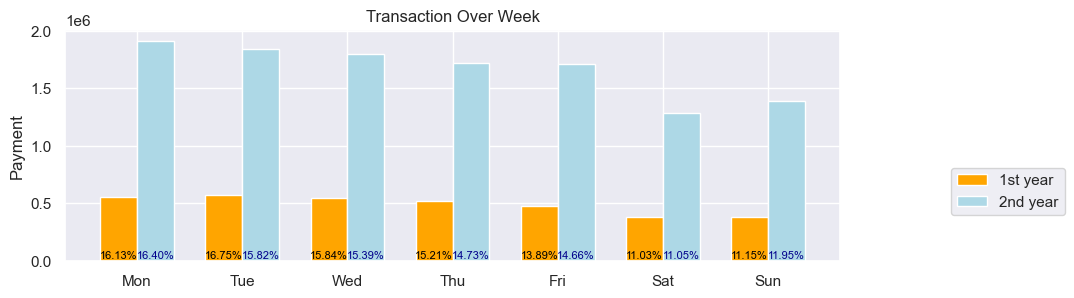

In [78]:
bar_width = 0.35
index = np.arange(len(df_payment_by_day_1st))

plt.figure(figsize=(10, 3))
plt.bar(index, df_payment_by_day_1st['payment_value'], bar_width, color='orange', label='1st year')
plt.bar(index + bar_width, df_payment_by_day_2nd['payment_value'], bar_width, color='lightblue', label='2nd year')

# payment amounts
for x, y1 in zip(index, (df_payment_by_day_1st['payment_value'] / df_payment_by_day_1st['payment_value'].sum()) * 100):
    plt.text(x, y1, f'{y1:.2f}%', ha='center', va='bottom', color='black', fontsize=8)

for x, y in zip(index, (df_payment_by_day_2nd['payment_value'] / df_payment_by_day_2nd['payment_value'].sum()) * 100):
    plt.text(x + bar_width, y, f'{y:.2f}%', ha='center', va='bottom', color='darkblue', fontsize=8)

plt.title('Transaction Over Week')
plt.ylabel('Payment')
plt.xticks(index + bar_width / 2, df_payment_by_day_1st['Day_Name'])
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.3))
plt.show()

In [79]:
# Group by 'Day' and sum the 'payment' for each day
df_payment_by_city_1st = df_1st.groupby('customer_city')['payment_value'].sum().reset_index()
df_payment_by_city_2nd = df_2nd.groupby('customer_city')['payment_value'].sum().reset_index()

df_payment_by_state_1st = df_1st.groupby('customer_state')['payment_value'].sum().reset_index()
df_payment_by_state_2nd = df_2nd.groupby('customer_state')['payment_value'].sum().reset_index()

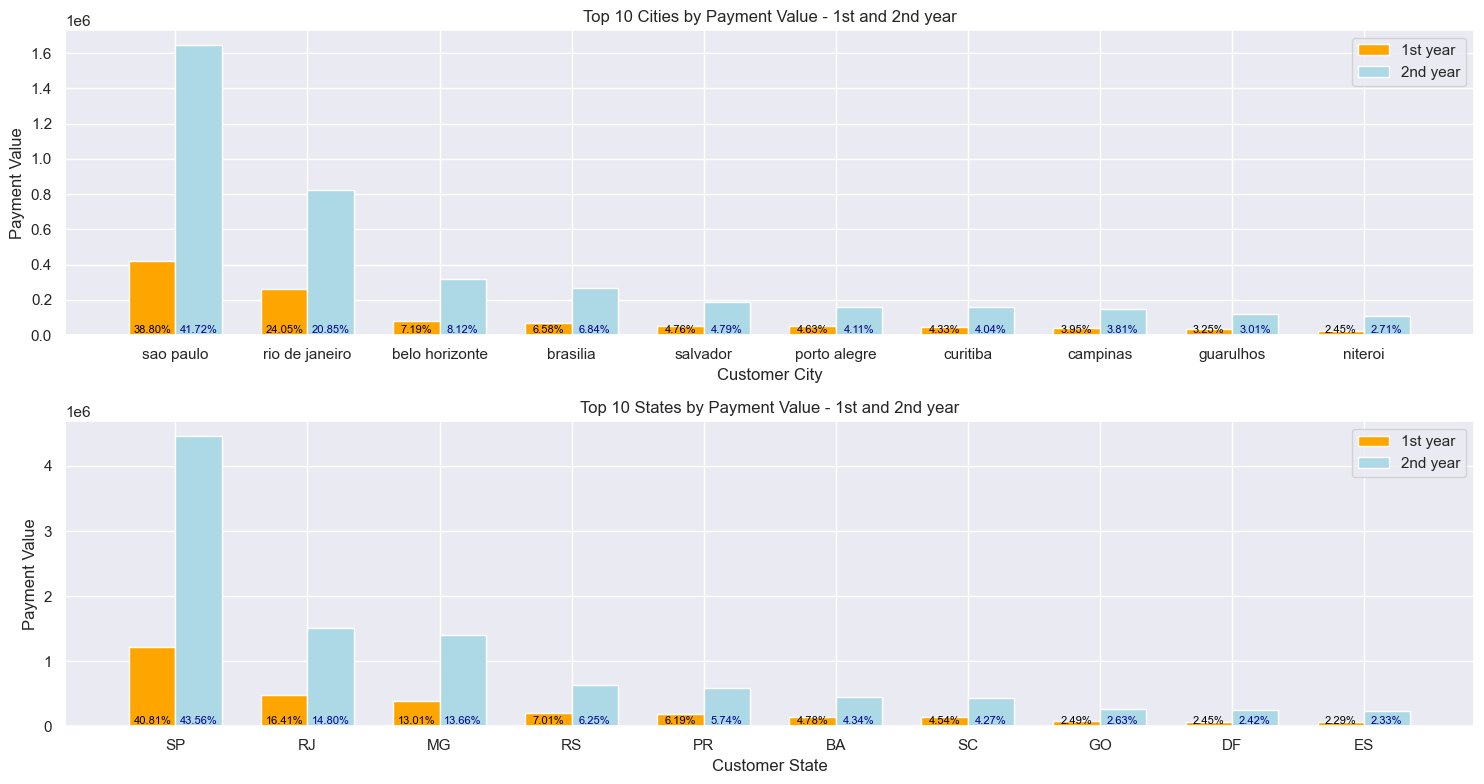

In [80]:
# Sort by 'payment_value' in descending order and select the top 10 cities
top_cities_1st = df_payment_by_city_1st.nlargest(10, 'payment_value')
top_states_1st = df_payment_by_state_1st.nlargest(10, 'payment_value')

top_cities_2nd = df_payment_by_city_2nd.nlargest(10, 'payment_value')
top_states_2nd = df_payment_by_state_2nd.nlargest(10, 'payment_value')

index = np.arange(len(top_cities_1st))

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

axes[0].bar(index, top_cities_1st['payment_value'], bar_width, color='orange', label='1st year')
axes[0].bar(index + bar_width, top_cities_2nd['payment_value'], bar_width, color='lightblue', label='2nd year')
for x, y1, y2 in zip(index, (top_cities_1st['payment_value'] / top_cities_1st['payment_value'].sum()) * 100,
                    (top_cities_2nd['payment_value'] / top_cities_2nd['payment_value'].sum()) * 100):
    axes[0].text(x, y1, f'{y1:.2f}%', ha='center', va='bottom', color='black', fontsize=8)
    axes[0].text(x + bar_width, y2, f'{y2:.2f}%', ha='center', va='bottom', color='darkblue', fontsize=8)

axes[0].set_title('Top 10 Cities by Payment Value - 1st and 2nd year')
axes[0].set_xlabel('Customer City')
axes[0].set_ylabel('Payment Value')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(top_cities_1st['customer_city'])
axes[0].legend()

# Plot for the 1st year - States
axes[1].bar(index, top_states_1st['payment_value'], bar_width, color='orange', label='1st year')
axes[1].bar(index + bar_width, top_states_2nd['payment_value'], bar_width, color='lightblue', label='2nd year')
for x, y1, y2 in zip(index, (top_states_1st['payment_value'] / top_states_1st['payment_value'].sum()) * 100,
                    (top_states_2nd['payment_value'] / top_states_2nd['payment_value'].sum()) * 100):
    axes[1].text(x, y1, f'{y1:.2f}%', ha='center', va='bottom', color='black', fontsize=8)
    axes[1].text(x + bar_width, y2, f'{y2:.2f}%', ha='center', va='bottom', color='darkblue', fontsize=8)

axes[1].set_title('Top 10 States by Payment Value - 1st and 2nd year')
axes[1].set_xlabel('Customer State')
axes[1].set_ylabel('Payment Value')
axes[1].set_xticks(index + bar_width / 2)
axes[1].set_xticklabels(top_states_1st['customer_state'])
axes[1].legend()

plt.tight_layout()
plt.show()

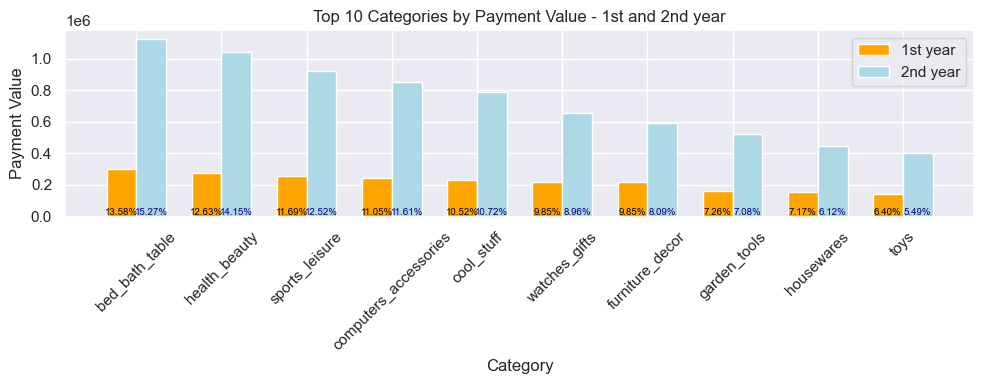

In [81]:
# Group by 'Day' and sum the 'payment' for each day
df_payment_by_categories_1st = df_1st.groupby('product_category_name')['payment_value'].sum().reset_index()
df_payment_by_categories_2nd = df_2nd.groupby('product_category_name')['payment_value'].sum().reset_index()

# Sort by 'payment_value' in descending order and select the top 10 cities
top_categories_1st = df_payment_by_categories_1st.nlargest(10, 'payment_value')
top_categories_2nd = df_payment_by_categories_2nd.nlargest(10, 'payment_value')

bar_width = 0.35
index = np.arange(len(top_categories_1st))
plt.figure(figsize=(10, 4))

plt.bar(index, top_categories_1st['payment_value'], bar_width, color='orange', label='1st year')
plt.bar(index + bar_width, top_categories_2nd['payment_value'], bar_width, color='lightblue', label='2nd year')

for x, y1, y2 in zip(index,(top_categories_1st['payment_value']/ top_categories_1st['payment_value'].sum())*100,
                    (top_categories_2nd['payment_value']/ top_categories_2nd['payment_value'].sum())*100):
    plt.text(x, y1, f'{y1:.2f}%', ha='center', va='bottom', color='black', fontsize=7)
    plt.text(x + bar_width, y2, f'{y2:.2f}%', ha='center', va='bottom', color='darkblue', fontsize=7)

plt.title('Top 10 Categories by Payment Value - 1st and 2nd year')
plt.xlabel('Category')
plt.ylabel('Payment Value')
plt.xticks(index + bar_width / 2, top_categories_1st['product_category_name'],rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


   Year  customer_unique_id
0  2016                 258
1  2017               41098
2  2018               50741


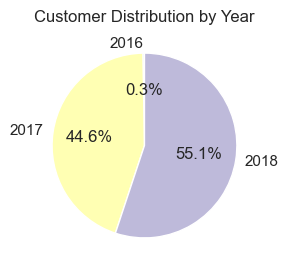

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


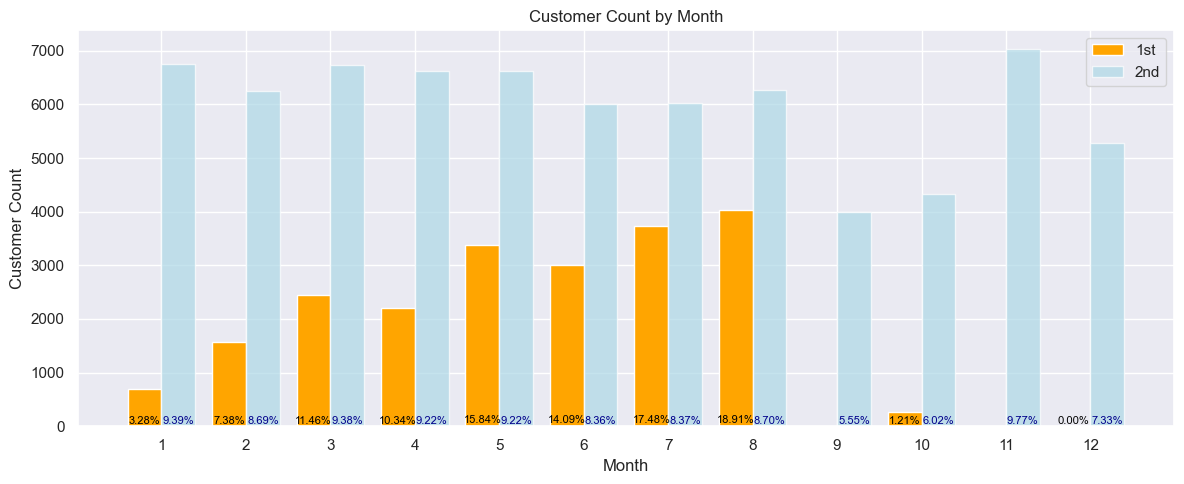

In [82]:
# Group by 'Year' and count 'customer_unique_id'-- pie plot
customer_count_by_year = df.groupby('Year')['customer_unique_id'].nunique().reset_index()
print(customer_count_by_year)
plt.figure(figsize=(3, 3))
plt.pie(customer_count_by_year['customer_unique_id'], labels=customer_count_by_year['Year'], colors=plt.cm.Set3.colors, autopct='%1.1f%%', startangle=90)
plt.title('Customer Distribution by Year')
plt.show()

months_range=range(1, 13)
plt.figure(figsize=(12, 5))
# Group by 'Month' , separate by year and count 'customer_unique_id'
customer_count_by_month_1st=df_1st.groupby('Month')['customer_unique_id'].nunique().reset_index()
customer_count_by_month_2nd=df_2nd.groupby('Month')['customer_unique_id'].nunique().reset_index()
customer_count_by_month_1st = customer_count_by_month_1st.set_index('Month').reindex(months_range).reset_index()
customer_count_by_month_2nd = customer_count_by_month_2nd.set_index('Month').reindex(months_range).reset_index()
bar_width = 0.4
index = np.arange(len(customer_count_by_month_1st['Month']))
plt.bar(index, customer_count_by_month_1st['customer_unique_id'], bar_width, color='orange', label='1st')
plt.bar(index + bar_width, customer_count_by_month_2nd['customer_unique_id'], bar_width, alpha=0.7, color='lightblue', label='2nd')
for x, y1, y2 in zip(index, (customer_count_by_month_1st['customer_unique_id'] / customer_count_by_month_1st['customer_unique_id'].sum()) * 100,
                    (customer_count_by_month_2nd['customer_unique_id'] / customer_count_by_month_2nd['customer_unique_id'].sum()) * 100):
    plt.text(x, y1, f'{y1:.2f}%', ha='center', va='bottom', color='black', fontsize=8)
    plt.text(x + bar_width, y2, f'{y2:.2f}%', ha='center', va='bottom', color='darkblue', fontsize=8)

plt.title('Customer Count by Month')
plt.xlabel('Month')
plt.ylabel('Customer Count')
plt.xticks(index + bar_width / 2, months_range)
plt.legend()
plt.tight_layout()
plt.show()

The Chi-Square Test for Independence is designed for categorical variables, and it assumes that the observations are independent. Outliers, in the traditional sense, may not impact the test directly because the test deals with counts or frequencies in contingency tables.

In [83]:
df[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'shipping_limit_date', 'order_estimated_delivery_date','order_delivered_customer_date']].head(3)

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_estimated_delivery_date,order_delivered_customer_date
0,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-22 15:22:12,2017-06-05,2017-05-25 10:35:35
1,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-23 00:47:18,2017-12-19,2017-11-28 00:09:50
2,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-22 22:22:56,2017-06-12,2017-05-26 09:54:04


* order_purchase_timestamp: The timestamp when the customer places the or
* order_approved_at: meaning it was confirmed and accepted by the system for further processing
* order_delivered_carrier_date: timestamp or date and time, seller to the carrier(shipping)
* shipping_limit_date:  deadline or limit by which the seller is expected to hand over the order to the carrier for shipping  
* order_estimated_delivery_date:
* order_delivered_customer_date:

In [84]:
df['Order_Processing_Time']=(df['order_approved_at']-df['order_purchase_timestamp']).dt.days  # in days
df['Shipping_Delay']=(df['shipping_limit_date']-df['order_delivered_carrier_date']).dt.days  # in days
# #creat meaningful data range 
df['delivery_delay'] = (df['order_delivered_customer_date']-df['order_estimated_delivery_date']).dt.days  # in days

In [85]:
Q1 = df['Shipping_Delay'].quantile(0.25)
Q3 = df['Shipping_Delay'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (df['Shipping_Delay'] >= lower_bound) & (df['Shipping_Delay'] <= upper_bound)
df = df[mask]

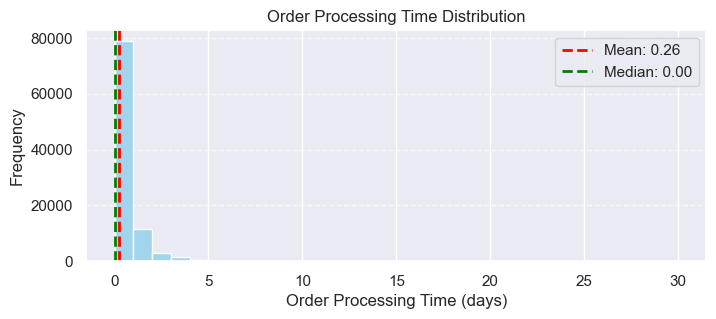

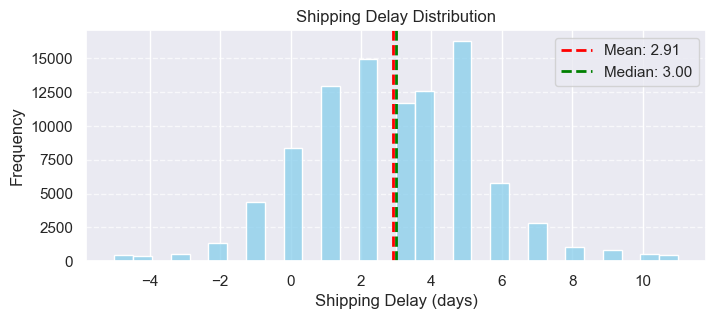

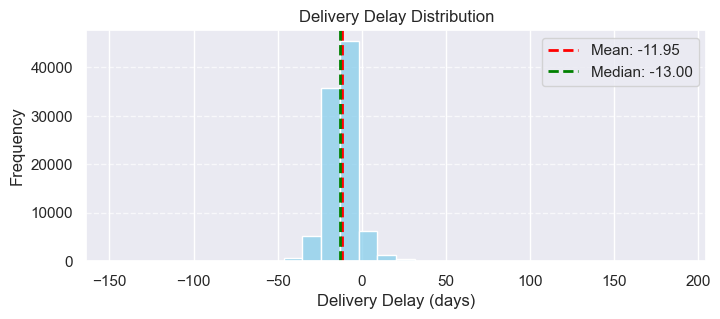

percentage of Order_Processing_Time delay 17.3
percentage of Shipping delay 83.75
percentage of delivery delay 5.98


In [86]:
sns.set(style="darkgrid")

# Order Processing Time Distribution
plt.figure(figsize=(8, 3))
sns.histplot(df['Order_Processing_Time'], bins=30, color='skyblue', edgecolor='white')
plt.title('Order Processing Time Distribution')
plt.xlabel('Order Processing Time (days)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

mean_order_processing_time = df['Order_Processing_Time'].mean()
median_order_processing_time = df['Order_Processing_Time'].median()
plt.axvline(mean_order_processing_time, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_order_processing_time:.2f}')
plt.axvline(median_order_processing_time, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_order_processing_time:.2f}')
plt.legend()
plt.show()

# Shipping Delay Distribution
plt.figure(figsize=(8, 3))
sns.histplot(df['Shipping_Delay'], bins=30, color='skyblue', edgecolor='white')
plt.title('Shipping Delay Distribution')
plt.xlabel('Shipping Delay (days)')
plt.ylabel('Frequency')

mean_shipping_delay = df['Shipping_Delay'].mean()
median_shipping_delay = df['Shipping_Delay'].median()

plt.axvline(mean_shipping_delay, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_shipping_delay:.2f}')
plt.axvline(median_shipping_delay, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_shipping_delay:.2f}')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Delivery Delay Distribution
plt.figure(figsize=(8, 3))
sns.histplot(df['delivery_delay'], bins=30, color='skyblue', edgecolor='white')
plt.title('Delivery Delay Distribution')
plt.xlabel('Delivery Delay (days)')
plt.ylabel('Frequency')

mean_delivery_delay = df['delivery_delay'].mean()
median_delivery_delay = df['delivery_delay'].median()

plt.axvline(mean_delivery_delay, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_delivery_delay:.2f}')
plt.axvline(median_delivery_delay, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_delivery_delay:.2f}')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


print('percentage of Order_Processing_Time delay',round(df[df['Order_Processing_Time']>0]['Order_Processing_Time'].count()/df['order_estimated_delivery_date'].count()*100,2))
print('percentage of Shipping delay',round((df[df['Shipping_Delay'] > 0]['Shipping_Delay'].count()/df['order_estimated_delivery_date'].count()* 100),2))
print('percentage of delivery delay',round(df[df['delivery_delay'] > 0]['delivery_delay'].count()/df['order_estimated_delivery_date'].count()*100,2))

                       review_score  Order_Processing_Time  Shipping_Delay  \
review_score               1.000000              -0.014289        0.057894   
Order_Processing_Time     -0.014289               1.000000        0.031517   
Shipping_Delay             0.057894               0.031517        1.000000   
delivery_delay            -0.252785               0.034069       -0.228944   
payment_value             -0.034546               0.020753       -0.006907   

                       delivery_delay  payment_value  
review_score                -0.252785      -0.034546  
Order_Processing_Time        0.034069       0.020753  
Shipping_Delay              -0.228944      -0.006907  
delivery_delay               1.000000      -0.025379  
payment_value               -0.025379       1.000000  


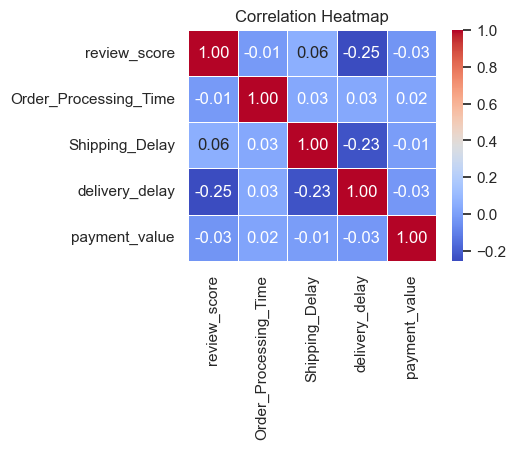

In [87]:
socre_columns = ['Order_Processing_Time', 'Shipping_Delay', 'delivery_delay','payment_value']
correlation_matrix = df[['review_score']+socre_columns ].corr()
# correlation matrix
print(correlation_matrix)
# heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [88]:
df['delay'] = np.where(df['delivery_delay'] > 0, 1, 0)
df.head()
contingency_table = pd.crosstab(df['review_score'], df['delay'])
print(contingency_table)
# Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")

delay             0     1
review_score             
1              5846  2995
2              2363   493
3              7204   642
4             18309   599
5             55930   969
Chi-Square Value: 15078.03554837241
P-value: 0.0


#### Model to extract further relationship or insights

In [89]:
df_model=df.copy()

columns_to_drop = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                   'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date',
                  'order_id','customer_zip_code_prefix','Year_Month','customer_unique_id','delay']

df_model = df_model.drop(columns=columns_to_drop)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95350 entries, 0 to 99202
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_city           95350 non-null  object 
 1   customer_state          95350 non-null  object 
 2   price                   95350 non-null  float64
 3   freight_value           95350 non-null  float64
 4   sum_value               95350 non-null  float64
 5   product_category_name   95329 non-null  object 
 6   seller_zip_code_prefix  95350 non-null  int64  
 7   seller_city             95350 non-null  object 
 8   seller_state            95350 non-null  object 
 9   review_score            95350 non-null  int64  
 10  payment_value           95350 non-null  float64
 11  Year                    95350 non-null  int32  
 12  Month                   95350 non-null  int32  
 13  Order_Processing_Time   95337 non-null  float64
 14  Shipping_Delay          95350 non-null  flo

In [90]:
df1=df.copy()
df1=df1.drop_duplicates(subset=['customer_zip_code_prefix'])
df1=df1.dropna()
df.shape
olist_geolocation = olist_geolocation.dropna()
olist_geolocation = olist_geolocation.drop_duplicates(['customer_zip_code_prefix'])
olist_geolocation.shape

(19015, 5)

In [91]:
df_customer_geo=pd.merge(df1,olist_geolocation,on='customer_zip_code_prefix',how='inner')
df_customer_geo.drop_duplicates()
df_customer_geo.shape

(14586, 31)

In [92]:
lats_longs_weight = list(map(list, zip(df_customer_geo["geolocation_lat"],
                          df_customer_geo["geolocation_lng"],
                          df_customer_geo["payment_value"]
                         )
               )
           )
lats_longs_weight[:5]

map_obj = folium.Map(location=[df_customer_geo['geolocation_lat'].mean(), df_customer_geo['geolocation_lng'].mean()], zoom_start=10)
HeatMap(lats_longs_weight).add_to(map_obj)
map_obj

sellers, geolocation

In [86]:
df2=df.copy()
##### convert with sellers
olist_geolocation = pd.read_csv('C:/Users/13587/Desktop/case aldi/olist_geolocation_dataset.csv')
olist_geolocation.rename(columns={'geolocation_zip_code_prefix': 'seller_zip_code_prefix'}, inplace=True)
df2=df2.drop_duplicates(subset=['seller_zip_code_prefix'])
df2=df2.dropna()
df2.shape
olist_geolocation = olist_geolocation.dropna()
olist_geolocation = olist_geolocation.drop_duplicates(['seller_zip_code_prefix'])
olist_geolocation.shape
df_seller_geo=pd.merge(df2,olist_geolocation,on='seller_zip_code_prefix',how='inner')
df_seller_geo.drop_duplicates()
df_seller_geo.shape
df_seller_geo.head(2)
df_customer_geo.head(2)
cols1=['Order_Processing_Time', 'Shipping_Delay', 'delivery_delay','payment_value','order_id','geolocation_lat','geolocation_lng','customer_zip_code_prefix']
cols2=['order_id','geolocation_lat','geolocation_lng','seller_zip_code_prefix']
df_customer_geo[cols1].drop_duplicates(subset=['order_id'])
df_customer_geo[cols1].shape
df_seller_geo[cols2].drop_duplicates(subset=['order_id'])
df_seller_geo[cols2].shape
df_distance=pd.merge(df_customer_geo[cols1],df_seller_geo[cols2], on='order_id', how='inner')
df_distance.shape
df_distance.head()

* Random forest to predict the customers review_score(1,2,3,4,5)
* Features: merge most of the dataset and drop inappropriate columns, with categorical and numerical features
* Multiple classification problems with the mildly imbalanced dataset also can choose RF/XGBoosting/SVM/Logistic Reg model
* RF can select the features automatically and mitigate overfitting, more robust, computationally expensive than others
* while it doesn't show good performance when I print the confusion matrix
* Classification Metrics: accuracy, precision, recall, F1 score, pr-roc ...

In [93]:
df_model=df_model.dropna()
target = df_model['review_score']
features = df_model.drop('review_score', axis=1)

categorical_features = features.select_dtypes(include=['object']).columns

# One-hot encoding for categorical features
features = pd.get_dummies(features, columns=categorical_features, drop_first=True)

In [94]:
#from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Cross-validation
# cv_scores = cross_val_score(clf, features, target, cv=5, scoring='accuracy')  
# print("Cross-Validation Scores:", cv_scores)
# print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Accuracy on Test Set: 0.63


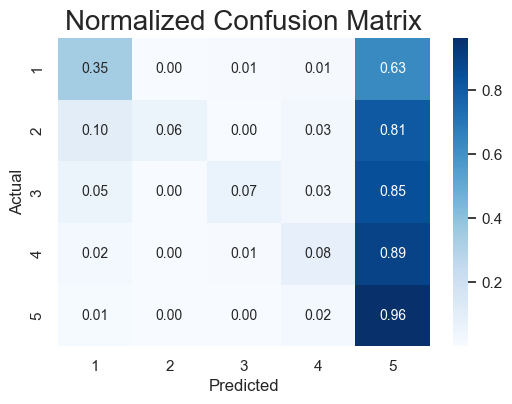

In [96]:
# Accuracy on the test set
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on Test Set: {accuracy:.2f}")
class_labels  = ['1','2','3','4','5']

conf_matrix = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix by dividing each row by the sum of that row
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm_normalized_df = pd.DataFrame(cm_normalized, columns=class_labels, index=class_labels)
cm_normalized_df.index.name = 'Actual'
cm_normalized_df.columns.name = 'Predicted'
plt.figure(figsize=(6, 4))
plt.title('Normalized Confusion Matrix', fontsize=20)

sns.set(font_scale=1)
ax = sns.heatmap(cm_normalized_df, cbar=True, cmap='Blues', annot=True, annot_kws={'size': 10}, fmt='.2f')
plt.savefig('normalized_confusion_matrix.png', bbox_inches='tight')
plt.show()

* clustering depending on given information from customers with 4 numerical_features and 2 categorical_features
* 
numerical_features = df_model[['payment_value','price','freight_value','review_score']]  
categorical_features = df_model[['customer_state', 'product_category_name']]

* The k-means (hierarchical) method is usually chosen for clustering, but the samples are more complex.

* I want to find customers with different values, which product they like best, which cities they come from, the price they paid, whether they are satisfied with the shipping or quality (ratings)

In [97]:
features.head()

,price,freight_value,sum_value,seller_zip_code_prefix,payment_value,Year,Month,Order_Processing_Time,Shipping_Delay,delivery_delay,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,124.99,21.88,146.87,8577,146.87,2017,5,0.0,-1.0,-11.0,...,False,False,False,False,False,False,False,False,False,True
1,112.99,24.90,275.78,8577,275.79,2017,11,0.0,0.0,-21.0,...,False,False,False,False,False,False,False,False,False,True
2,124.99,15.62,140.61,8577,140.61,2017,5,1.0,3.0,-17.0,...,False,False,False,False,False,False,False,False,False,True
3,106.99,30.59,137.58,8577,137.58,2018,2,1.0,-1.0,-22.0,...,False,False,False,False,False,False,False,False,False,True
4,126.99,15.06,142.05,8577,142.05,2017,3,0.0,7.0,-13.0,...,False,False,False,False,False,False,False,False,False,True


In [98]:
df_model.head()

,customer_city,customer_state,price,freight_value,sum_value,product_category_name,seller_zip_code_prefix,seller_city,seller_state,review_score,payment_value,Year,Month,Order_Processing_Time,Shipping_Delay,delivery_delay
0,franca,SP,124.99,21.88,146.87,office_furniture,8577,itaquaquecetuba,SP,4,146.87,2017,5,0.0,-1.0,-11.0
1,santarem,PA,112.99,24.90,275.78,office_furniture,8577,itaquaquecetuba,SP,1,275.79,2017,11,0.0,0.0,-21.0
2,nova santa rita,RS,124.99,15.62,140.61,office_furniture,8577,itaquaquecetuba,SP,3,140.61,2017,5,1.0,3.0,-17.0
3,mage,RJ,106.99,30.59,137.58,office_furniture,8577,itaquaquecetuba,SP,4,137.58,2018,2,1.0,-1.0,-22.0
4,angelina,SC,126.99,15.06,142.05,office_furniture,8577,itaquaquecetuba,SP,4,142.05,2017,3,0.0,7.0,-13.0


K-Prototypes combines the K-Means algorithm with the K-Modes algorithm, allowing it to handle mixed-type data. 

In [99]:
numerical_features = df_model[['payment_value','price','freight_value','review_score']]  
categorical_features = df_model[['customer_state',
                                'product_category_name']]
features_for_clustering = pd.concat([numerical_features, categorical_features], axis=1)
k = 3
categorical_indices = list(range(len(numerical_features.columns), len(features_for_clustering.columns)))
# K-Prototypes Clustering
kproto = KPrototypes(n_clusters=k, init='Cao', n_init=5,verbose=2)
df_model['cluster_label'] = kproto.fit_predict(features_for_clustering, categorical=categorical_indices)

print(df_model['cluster_label'].value_counts())

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 20525, ncost: 3177927816.490422
Run: 1, iteration: 2/100, moves: 7849, ncost: 2621528290.582028
Run: 1, iteration: 3/100, moves: 7092, ncost: 2467405371.260159
Run: 1, iteration: 4/100, moves: 5246, ncost: 2370778374.6942296
Run: 1, iteration: 5/100, moves: 3981, ncost: 2315633411.1559496
Run: 1, iteration: 6/100, moves: 2715, ncost: 2278892554.234024
Run: 1, iteration: 7/100, moves: 2183, ncost: 2252377680.4259763
Run: 1, iteration: 8/100, moves: 1676, ncost: 2227565880.2644997
Run: 1, iteration: 9/100, moves: 1182, ncost: 2214836137.4595375
Run: 1, iteration: 10/100, moves: 810, ncost: 2205878047.8318124
Run: 1, iteration: 11/100, moves: 508, ncost: 2202510170.266405
Run: 1, iteration: 12/100, moves: 347, ncost: 2201366071.513183
Run: 1, iteration: 13/100, moves: 186, ncost: 2201122651.4719276
Run:

In [100]:
print(df_model[['payment_value','review_score', 'customer_state', 'price','freight_value','product_category_name', 'cluster_label']].head())

   payment_value  review_score customer_state   price  freight_value  \
0         146.87             4             SP  124.99          21.88   
1         275.79             1             PA  112.99          24.90   
2         140.61             3             RS  124.99          15.62   
3         137.58             4             RJ  106.99          30.59   
4         142.05             4             SC  126.99          15.06   

  product_category_name  cluster_label  
0      office_furniture              2  
1      office_furniture              2  
2      office_furniture              2  
3      office_furniture              2  
4      office_furniture              2  


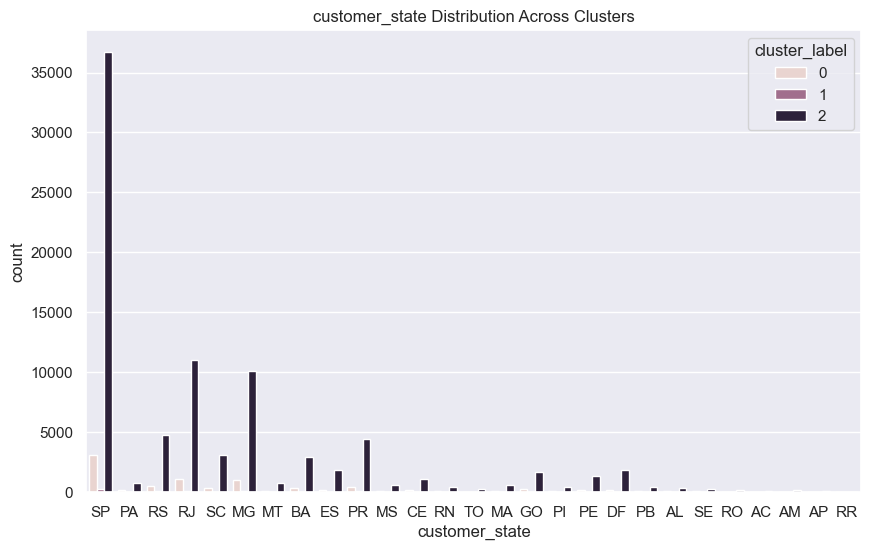

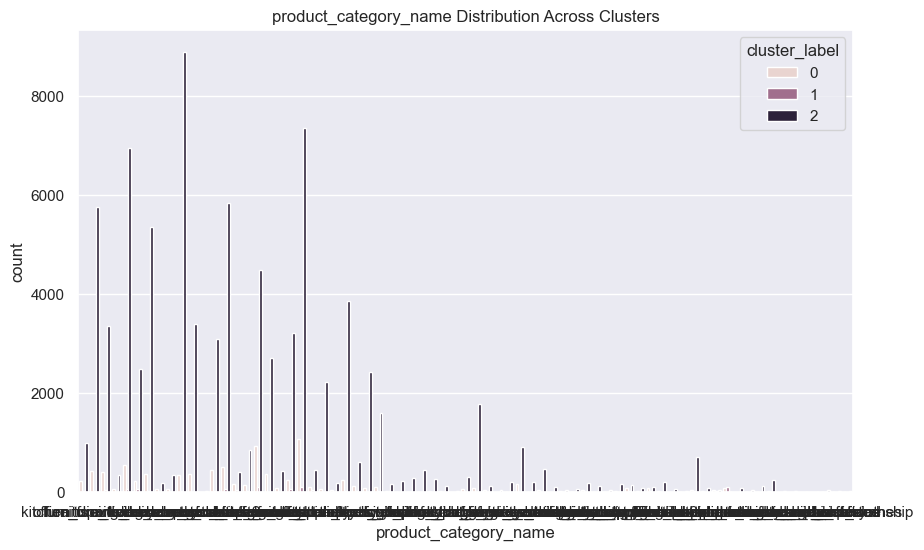

In [104]:
# for feature in numerical_features.columns:
#     sns.boxplot(x='cluster_label', y=feature, data=df_model)
#     plt.title(f'{feature} Across Clusters')
#     plt.show()
for feature in categorical_features.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='cluster_label', data=df_model)
    plt.title(f'{feature} Distribution Across Clusters')
    plt.show()

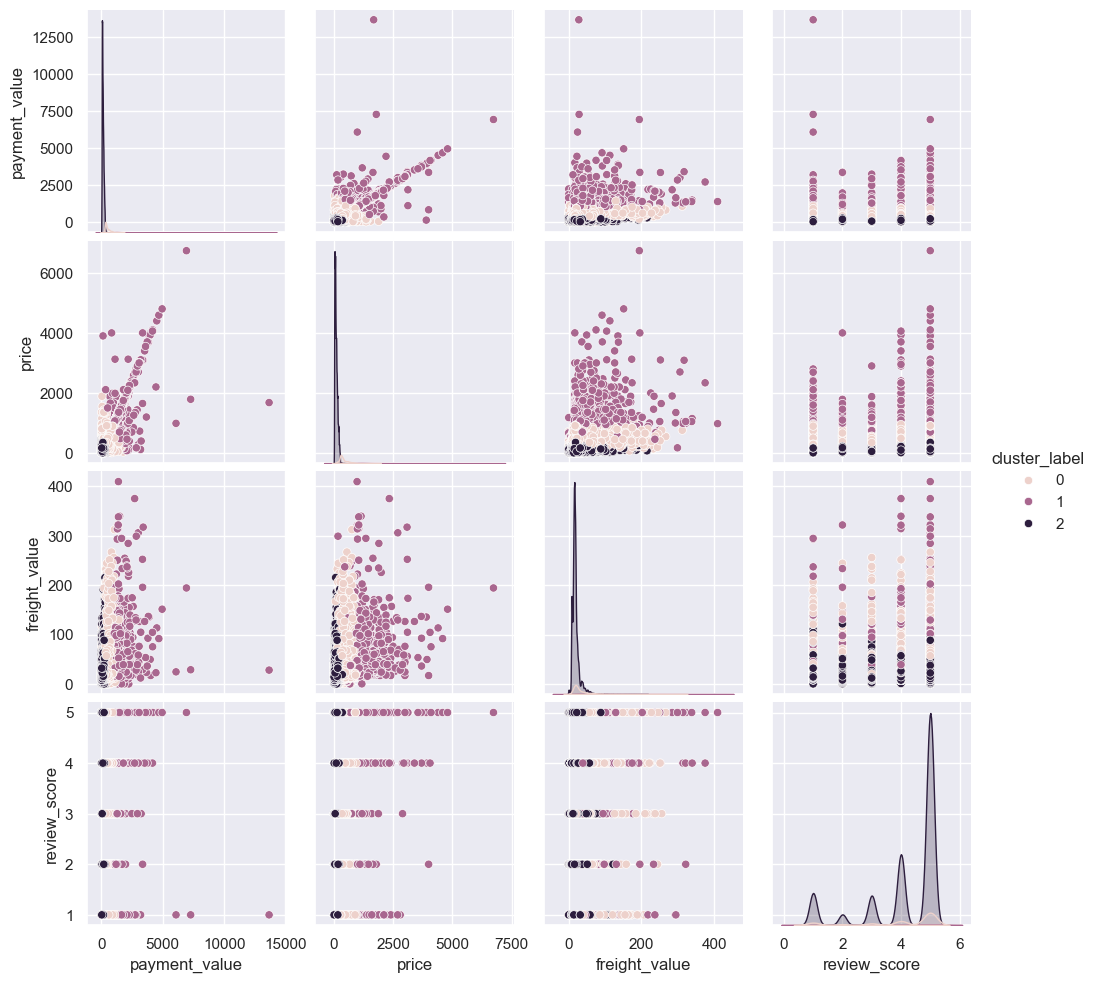

In [105]:
sns.pairplot(df_model, hue='cluster_label', vars=numerical_features.columns)
plt.show()

In [106]:
cluster_summary = df_model.groupby('cluster_label').agg({
    'payment_value': ['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'review_score': 'median',
    'customer_state': lambda x: x.value_counts().index[:3].tolist(),
    'product_category_name': lambda x: x.value_counts().index[:3].tolist()
}).rename(columns={'customer_state': 'top_customer_states'}).reset_index()

cluster_summary.columns = ['Cluster Label', 'Payment Value (Median)', 'Payment Value (Q1)', 'Payment Value (Q3)',
                           'Review Score (Median)', 'Top Customer States', 'Top Product Categories']

print(tabulate(cluster_summary, headers='keys', tablefmt='pretty', showindex=False))

+---------------+------------------------+--------------------+--------------------+-----------------------+---------------------+-------------------------------------------------------+
| Cluster Label | Payment Value (Median) | Payment Value (Q1) | Payment Value (Q3) | Review Score (Median) | Top Customer States |                Top Product Categories                 |
+---------------+------------------------+--------------------+--------------------+-----------------------+---------------------+-------------------------------------------------------+
|       0       |   409.32500000000005   |       330.13       |      570.7525      |          5.0          | ['SP', 'RJ', 'MG']  | ['health_beauty', 'watches_gifts', 'sports_leisure']  |
|       1       |         1364.8         |      1148.45       |      1807.635      |          5.0          | ['SP', 'RJ', 'MG']  |    ['computers', 'watches_gifts', 'health_beauty']    |
|       2       |         89.62          |       53.65        |  

Time series for prediction payment(revenue)

In [107]:
df_transection['Year_Month']=pd.to_datetime(df_transection['Year_Month'],format='%Y-%m')

In [108]:
df_transection.info

<bound method DataFrame.info of    Year_Month  payment_value
0  2016-10-01       45630.83
1  2016-12-01          19.62
2  2017-01-01      122135.32
3  2017-02-01      260208.24
4  2017-03-01      401922.47
5  2017-04-01      378391.44
6  2017-05-01      549774.10
7  2017-06-01      482335.69
8  2017-07-01      557893.57
9  2017-08-01      635091.86
10 2017-09-01      688955.07
11 2017-10-01      727370.36
12 2017-11-01     1128687.74
13 2017-12-01      814704.68
14 2018-01-01     1046589.41
15 2018-02-01      948239.67
16 2018-03-01     1091712.48
17 2018-04-01     1116931.52
18 2018-05-01     1117421.65
19 2018-06-01     1005278.09
20 2018-07-01     1009227.62
21 2018-08-01      977640.39>

In [109]:
filter_rows = df_transection[(df_transection['Year_Month'] == '2016-10-01') | (df_transection['Year_Month'] == '2016-12-01')]

# Calculate the mean of 'payment'  of 2016-11
daytime = datetime(2016, 11, 1)

new_row = pd.DataFrame({'Year_Month': [daytime.strftime('%Y-%m')], 'payment_value': [15010.59]})
print(new_row)
# Concatenate the new row to the original DataFrame
df_transection = pd.concat([df_transection, new_row], ignore_index=True)


  Year_Month  payment_value
0    2016-11       15010.59


In [110]:
df_transection = pd.concat([df_transection.iloc[0:1], df_transection.iloc[22:], df_transection.iloc[1:22]])
df_transection = df_transection.reset_index(drop=True)

In [111]:
df_transection.index = df_transection['Year_Month']
del df_transection['Year_Month']
print(df_transection.head())

                     payment_value
Year_Month                        
2016-10-01 00:00:00       45630.83
2016-11                   15010.59
2016-12-01 00:00:00          19.62
2017-01-01 00:00:00      122135.32
2017-02-01 00:00:00      260208.24


In [112]:
rolling_mean = df_transection.rolling(6).mean()
rolling_std = df_transection.rolling(6).std()

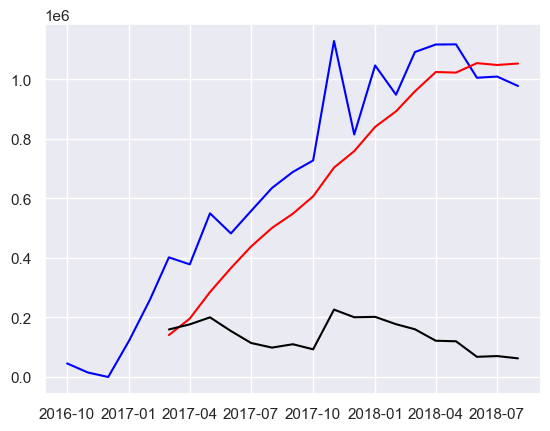

In [113]:
plt.plot(df_transection, color="blue",label="Original xx Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean xx")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in xx")

In [114]:
adft = adfuller(df_transection,autolag="AIC")

In [115]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -1.794958              Test Statistics
1   0.382968                      p-value
2   1.000000             No. of lags used
3  21.000000  Number of observations used
4  -3.788386          critical value (1%)
5  -3.013098          critical value (5%)
6  -2.646397         critical value (10%)


In [116]:
autocorrelation_lag1 = df_transection['payment_value'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

One Month Lag:  0.9316418001550049


In [117]:
autocorrelation_lag3 = df_transection['payment_value'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df_transection['payment_value'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df_transection['payment_value'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

Three Month Lag:  0.8933556989712699
Six Month Lag:  0.8720519638816824
Nine Month Lag:  0.6618260351094226


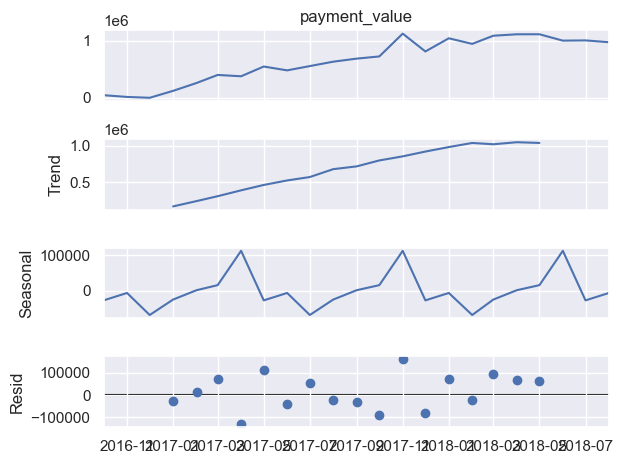

In [118]:
decompose = seasonal_decompose(df_transection['payment_value'],model='additive', period=7)
decompose.plot()
plt.show()

In [119]:
df_transection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 2016-10-01 00:00:00 to 2018-08-01 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   payment_value  23 non-null     float64
dtypes: float64(1)
memory usage: 368.0+ bytes


In [120]:
df_transection['Date'] = df_transection.index
df_transection['Date'] = pd.to_datetime(df_transection['Date'],format='%Y-%m')
df_transection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 2016-10-01 00:00:00 to 2018-08-01 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   payment_value  23 non-null     float64       
 1   Date           23 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 552.0+ bytes


In [121]:
train = df_transection[df_transection['Date'] < pd.to_datetime("2018-03", format='%Y-%m')]
train['train'] = train['payment_value']
train = train[['train']]  # Keep only the 'train' column
test = df_transection[df_transection['Date'] >= pd.to_datetime("2018-03", format='%Y-%m')]
test['test'] = test['payment_value']
test = test[['test']]  # Keep only the 'test' column

In [122]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=439.904, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=431.571, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=424.205, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=434.405, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=431.624, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=426.486, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=426.645, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=430.285, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.398 seconds


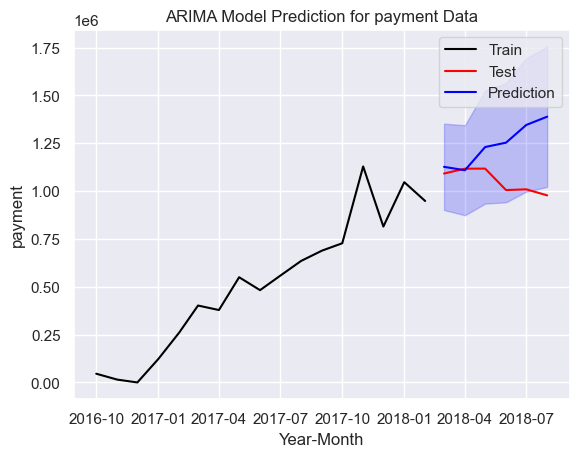

In [123]:
# Plot predictions
plt.plot(train, color = "black",label='Train')
plt.plot(test, color = "red",label='Test')
plt.title("Train/Test split for payment Data")
plt.ylabel("payment")
plt.xlabel('Year-Month')
plt.plot(forecast, color="blue", label='Prediction')
# Plot confidence interval
if conf_int is not None:
    plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='blue', alpha=0.2)

plt.title("ARIMA Model Prediction for payment Data")
plt.ylabel("payment")
plt.xlabel('Year-Month')
plt.legend()
sns.set()
plt.show()

In [124]:
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  244071.6555427715


reference:
https://builtin.com/data-science/time-series-python